In [8]:
import torch
from torch import nn, optim
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('white')
sys.path.insert(0, '../')
#from tta_agg_models import TTARegression, TTAPartialRegression, GPS
from utils.gpu_utils import restrict_GPU_pytorch
import numpy as np
from utils.aug_utils import invert_aug_list
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
restrict_GPU_pytorch('0')
class TTAPartialRegression(nn.Module):
    def __init__(self, n_augs, n_classes, temp_scale=1, initialization='even',coeffs=[]):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.coeffs = nn.Parameter(torch.randn((n_augs,1 ), requires_grad=True, dtype=torch.float))
        self.temperature = temp_scale
        if len(coeffs):
            self.coeffs = nn.Parameter(torch.Tensor(coeffs), requires_grad=True)
        else:
            if initialization == 'even':
                self.coeffs.data.fill_(1.0/n_augs)
            elif initialization== 'original':
                self.coeffs.data[0,:].fill_(1)
                self.coeffs.data[1,:].fill_(0)

    def forward(self, x):
        # Computes the outputs / predictions
        x = x/self.temperature
        mult = torch.matmul(x.transpose(1, 2), self.coeffs / torch.sum(self.coeffs, axis=0))
        return mult.squeeze()

class TTARegression(nn.Module):
    def __init__(self, n_augs, n_classes, temp_scale=1, initialization='even'):
        super().__init__()
        
        if initialization == 'even':
            self.coeffs = nn.Parameter(torch.randn((n_augs, n_classes), requires_grad=True, dtype=torch.float))
            self.coeffs.data.fill_(1.0/n_augs) 
        else:
            coeffs = torch.cat([torch.Tensor(initialization) for i in range(n_classes)], axis=1)
            self.coeffs = nn.Parameter(coeffs, requires_grad = True)

        self.temperature = temp_scale
    
    def forward(self, x):
        # Computes the outputs / predictions
        x = x/self.temperature
        mult = self.coeffs * x
        return mult.sum(axis=1)
cifar100_class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm']
stl10_class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 
                      'ship', 'truck']
flowers102_class_names = ['x' for i in range(102)]
imnet_class_names = ['x' for i in range(1000)]
#dataset, n_classes, model_name, class_names = 'stl10', 10, 'stl10_cnn', stl10_class_names
#dataset, n_classes, model_name, class_names = 'cifar100', 100, 'cifar100_cnn', cifar100_class_names
#dataset, n_classes, model_name, class_names = 'flowers102', 102, 'resnet50', flowers102_class_names
dataset, n_classes, model_name, class_names = 'imnet', 1000, 'resnet50', imnet_class_names
# policy = 'five_crop_hflip_scale'
# n_augs = 30
policy = 'pil'
n_augs = 200
agg_models_dir = '../' + dataset + '/' + policy + '/agg_models'

aug_name = 'combo'
aug_model_path = agg_models_dir + '/'+model_name+'/'+aug_name + '/partial_lr.pth'
aug_model = TTAPartialRegression(n_augs,n_classes,1,'even')
aug_model.load_state_dict(torch.load(aug_model_path))
aug_model.eval()
aug_coeffs = aug_model.coeffs.detach().cpu().numpy()

class_model_path = agg_models_dir + '/'+model_name+'/'+aug_name + '/full_lr.pth'
class_model = TTARegression(n_augs,n_classes,1,'even')
class_model.load_state_dict(torch.load(class_model_path))
class_model.eval()
class_coeffs = class_model.coeffs.detach().cpu().numpy()

aug_list = np.load('../' + dataset + '/' + policy + '/aug_list.npy')
aug_order = np.load('../' + dataset  + '/' + policy + '/aug_order.npy')
if policy == 'pil':
    aug_names = ['(<FlipLR(1.0,0)>,)', '(<FlipLR(1.0,1)>,)', '(<FlipLR(1.0,2)>,)', '(<FlipLR(1.0,3)>,)', '(<FlipLR(1.0,4)>,)', '(<FlipLR(1.0,5)>,)', '(<FlipLR(1.0,6)>,)', '(<FlipLR(1.0,7)>,)', '(<FlipLR(1.0,8)>,)', '(<FlipLR(1.0,9)>,)', '(<FlipUD(1.0,0)>,)', '(<FlipUD(1.0,1)>,)', '(<FlipUD(1.0,2)>,)', '(<FlipUD(1.0,3)>,)', '(<FlipUD(1.0,4)>,)', '(<FlipUD(1.0,5)>,)', '(<FlipUD(1.0,6)>,)', '(<FlipUD(1.0,7)>,)', '(<FlipUD(1.0,8)>,)', '(<FlipUD(1.0,9)>,)', '(<AutoContrast(1.0,0)>,)', '(<AutoContrast(1.0,1)>,)', '(<AutoContrast(1.0,2)>,)', '(<AutoContrast(1.0,3)>,)', '(<AutoContrast(1.0,4)>,)', '(<AutoContrast(1.0,5)>,)', '(<AutoContrast(1.0,6)>,)', '(<AutoContrast(1.0,7)>,)', '(<AutoContrast(1.0,8)>,)', '(<AutoContrast(1.0,9)>,)', '(<Equalize(1.0,0)>,)', '(<Equalize(1.0,1)>,)', '(<Equalize(1.0,2)>,)', '(<Equalize(1.0,3)>,)', '(<Equalize(1.0,4)>,)', '(<Equalize(1.0,5)>,)', '(<Equalize(1.0,6)>,)', '(<Equalize(1.0,7)>,)', '(<Equalize(1.0,8)>,)', '(<Equalize(1.0,9)>,)', '(<Invert(1.0,0)>,)', '(<Invert(1.0,1)>,)', '(<Invert(1.0,2)>,)', '(<Invert(1.0,3)>,)', '(<Invert(1.0,4)>,)', '(<Invert(1.0,5)>,)', '(<Invert(1.0,6)>,)', '(<Invert(1.0,7)>,)', '(<Invert(1.0,8)>,)', '(<Invert(1.0,9)>,)', '(<Rotate(1.0,0)>,)', '(<Rotate(1.0,1)>,)', '(<Rotate(1.0,2)>,)', '(<Rotate(1.0,3)>,)', '(<Rotate(1.0,4)>,)', '(<Rotate(1.0,5)>,)', '(<Rotate(1.0,6)>,)', '(<Rotate(1.0,7)>,)', '(<Rotate(1.0,8)>,)', '(<Rotate(1.0,9)>,)', '(<Posterize(1.0,0)>,)', '(<Posterize(1.0,1)>,)', '(<Posterize(1.0,2)>,)', '(<Posterize(1.0,3)>,)', '(<Posterize(1.0,4)>,)', '(<Posterize(1.0,5)>,)', '(<Posterize(1.0,6)>,)', '(<Posterize(1.0,7)>,)', '(<Posterize(1.0,8)>,)', '(<Posterize(1.0,9)>,)', '(<CropBilinear(1.0,0)>,)', '(<CropBilinear(1.0,1)>,)', '(<CropBilinear(1.0,2)>,)', '(<CropBilinear(1.0,3)>,)', '(<CropBilinear(1.0,4)>,)', '(<CropBilinear(1.0,5)>,)', '(<CropBilinear(1.0,6)>,)', '(<CropBilinear(1.0,7)>,)', '(<CropBilinear(1.0,8)>,)', '(<CropBilinear(1.0,9)>,)', '(<Solarize(1.0,0)>,)', '(<Solarize(1.0,1)>,)', '(<Solarize(1.0,2)>,)', '(<Solarize(1.0,3)>,)', '(<Solarize(1.0,4)>,)', '(<Solarize(1.0,5)>,)', '(<Solarize(1.0,6)>,)', '(<Solarize(1.0,7)>,)', '(<Solarize(1.0,8)>,)', '(<Solarize(1.0,9)>,)', '(<Color(1.0,0)>,)', '(<Color(1.0,1)>,)', '(<Color(1.0,2)>,)', '(<Color(1.0,3)>,)', '(<Color(1.0,4)>,)', '(<Color(1.0,5)>,)', '(<Color(1.0,6)>,)', '(<Color(1.0,7)>,)', '(<Color(1.0,8)>,)', '(<Color(1.0,9)>,)', '(<Contrast(1.0,0)>,)', '(<Contrast(1.0,1)>,)', '(<Contrast(1.0,2)>,)', '(<Contrast(1.0,3)>,)', '(<Contrast(1.0,4)>,)', '(<Contrast(1.0,5)>,)', '(<Contrast(1.0,6)>,)', '(<Contrast(1.0,7)>,)', '(<Contrast(1.0,8)>,)', '(<Contrast(1.0,9)>,)', '(<Brightness(1.0,0)>,)', '(<Brightness(1.0,1)>,)', '(<Brightness(1.0,2)>,)', '(<Brightness(1.0,3)>,)', '(<Brightness(1.0,4)>,)', '(<Brightness(1.0,5)>,)', '(<Brightness(1.0,6)>,)', '(<Brightness(1.0,7)>,)', '(<Brightness(1.0,8)>,)', '(<Brightness(1.0,9)>,)', '(<Sharpness(1.0,0)>,)', '(<Sharpness(1.0,1)>,)', '(<Sharpness(1.0,2)>,)', '(<Sharpness(1.0,3)>,)', '(<Sharpness(1.0,4)>,)', '(<Sharpness(1.0,5)>,)', '(<Sharpness(1.0,6)>,)', '(<Sharpness(1.0,7)>,)', '(<Sharpness(1.0,8)>,)', '(<Sharpness(1.0,9)>,)', '(<ShearX(1.0,0)>,)', '(<ShearX(1.0,1)>,)', '(<ShearX(1.0,2)>,)', '(<ShearX(1.0,3)>,)', '(<ShearX(1.0,4)>,)', '(<ShearX(1.0,5)>,)', '(<ShearX(1.0,6)>,)', '(<ShearX(1.0,7)>,)', '(<ShearX(1.0,8)>,)', '(<ShearX(1.0,9)>,)', '(<ShearY(1.0,0)>,)', '(<ShearY(1.0,1)>,)', '(<ShearY(1.0,2)>,)', '(<ShearY(1.0,3)>,)', '(<ShearY(1.0,4)>,)', '(<ShearY(1.0,5)>,)', '(<ShearY(1.0,6)>,)', '(<ShearY(1.0,7)>,)', '(<ShearY(1.0,8)>,)', '(<ShearY(1.0,9)>,)', '(<TranslateX(1.0,0)>,)', '(<TranslateX(1.0,1)>,)', '(<TranslateX(1.0,2)>,)', '(<TranslateX(1.0,3)>,)', '(<TranslateX(1.0,4)>,)', '(<TranslateX(1.0,5)>,)', '(<TranslateX(1.0,6)>,)', '(<TranslateX(1.0,7)>,)', '(<TranslateX(1.0,8)>,)', '(<TranslateX(1.0,9)>,)', '(<TranslateY(1.0,0)>,)', '(<TranslateY(1.0,1)>,)', '(<TranslateY(1.0,2)>,)', '(<TranslateY(1.0,3)>,)', '(<TranslateY(1.0,4)>,)', '(<TranslateY(1.0,5)>,)', '(<TranslateY(1.0,6)>,)', '(<TranslateY(1.0,7)>,)', '(<TranslateY(1.0,8)>,)', '(<TranslateY(1.0,9)>,)', '(<Cutout(1.0,0)>,)', '(<Cutout(1.0,1)>,)', '(<Cutout(1.0,2)>,)', '(<Cutout(1.0,3)>,)', '(<Cutout(1.0,4)>,)', '(<Cutout(1.0,5)>,)', '(<Cutout(1.0,6)>,)', '(<Cutout(1.0,7)>,)', '(<Cutout(1.0,8)>,)', '(<Cutout(1.0,9)>,)', '(<Blur(1.0,0)>,)', '(<Blur(1.0,1)>,)', '(<Blur(1.0,2)>,)', '(<Blur(1.0,3)>,)', '(<Blur(1.0,4)>,)', '(<Blur(1.0,5)>,)', '(<Blur(1.0,6)>,)', '(<Blur(1.0,7)>,)', '(<Blur(1.0,8)>,)', '(<Blur(1.0,9)>,)', '(<Smooth(1.0,0)>,)', '(<Smooth(1.0,1)>,)', '(<Smooth(1.0,2)>,)', '(<Smooth(1.0,3)>,)', '(<Smooth(1.0,4)>,)', '(<Smooth(1.0,5)>,)', '(<Smooth(1.0,6)>,)', '(<Smooth(1.0,7)>,)', '(<Smooth(1.0,8)>,)', '(<Smooth(1.0,9)>,)']
else:
    aug_names = invert_aug_list(aug_list, aug_order)
    


Using GPU:0


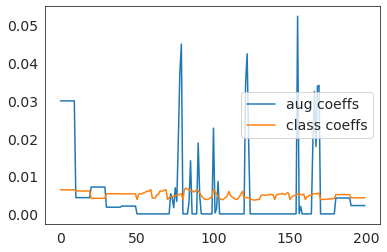

In [10]:
normalized_aug_coeffs = aug_coeffs/np.sum(aug_coeffs)
normalized_class_coeffs = np.sum(class_coeffs, axis=1)/np.sum(class_coeffs)
plt.plot(normalized_aug_coeffs, label='aug coeffs')
plt.plot(normalized_class_coeffs, label='class coeffs')
plt.legend()

In [12]:
# List augmentations in order of increasing learned coefficient
[(aug_names[i], normalized_aug_coeffs[i,0]) for i in np.argsort(normalized_aug_coeffs[:,0])]

[('(<Color(1.0,9)>,)', 0.0),
 ('(<Color(1.0,8)>,)', 0.0),
 ('(<Color(1.0,7)>,)', 0.0),
 ('(<Color(1.0,6)>,)', 0.0),
 ('(<Color(1.0,5)>,)', 0.0),
 ('(<Color(1.0,4)>,)', 0.0),
 ('(<Color(1.0,3)>,)', 0.0),
 ('(<ShearY(1.0,2)>,)', 0.0),
 ('(<ShearY(1.0,3)>,)', 0.0),
 ('(<Solarize(1.0,9)>,)', 0.0),
 ('(<Solarize(1.0,8)>,)', 0.0),
 ('(<Solarize(1.0,7)>,)', 0.0),
 ('(<Solarize(1.0,6)>,)', 0.0),
 ('(<ShearY(1.0,4)>,)', 0.0),
 ('(<ShearY(1.0,5)>,)', 0.0),
 ('(<Solarize(1.0,3)>,)', 0.0),
 ('(<Solarize(1.0,2)>,)', 0.0),
 ('(<Solarize(1.0,1)>,)', 0.0),
 ('(<Solarize(1.0,0)>,)', 0.0),
 ('(<ShearY(1.0,6)>,)', 0.0),
 ('(<ShearY(1.0,7)>,)', 0.0),
 ('(<ShearY(1.0,8)>,)', 0.0),
 ('(<ShearY(1.0,9)>,)', 0.0),
 ('(<TranslateX(1.0,0)>,)', 0.0),
 ('(<TranslateX(1.0,1)>,)', 0.0),
 ('(<TranslateX(1.0,2)>,)', 0.0),
 ('(<CropBilinear(1.0,1)>,)', 0.0),
 ('(<CropBilinear(1.0,0)>,)', 0.0),
 ('(<Posterize(1.0,9)>,)', 0.0),
 ('(<Posterize(1.0,8)>,)', 0.0),
 ('(<ShearY(1.0,1)>,)', 0.0),
 ('(<ShearX(1.0,4)>,)', 0.0),
 